In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians
pd.set_option('display.max_columns', None)

In [2]:
# SQL Read Helper class

class ReadSQL(object):
    """Helper class for connecting to SQL databases"""
    
    def __init__(self, db_name):
        self.db_name = db_name
        self.connection = None
        
    def connect(self):
        self.connection = sqlite3.connect(f"{self.db_name}")
        return self.connection
    
    def get(self, query, **kwargs):
        """Use pd.read_sql with default arguments to read from database"""
        if kwargs:
            sql_kwargs = kwargs
        else:
            sql_kwargs = {"con": self.connection, "parse_dates": "date"}
        return pd.read_sql(query, **sql_kwargs)

    def get_table_columns(self, table, **kwargs):
        """Returns dataframe info for a given table (most useful: column names and dtypes)"""
        query = f"SELECT * FROM {table} LIMIT 1;"
        return self.get(query, **kwargs).info()

                                          
readsql = ReadSQL("data/housing_data.db") 
conn = readsql.connect()

# Fetch and print table names
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:")
tables = [t[0] for t in res.fetchall()]
tables

Tables:


['listings',
 'venues',
 'calendar',
 'econ_state',
 'demographics',
 'real_estate',
 'deepsolar_tract']

### Load new listing dataset

In [3]:
listings_df = pd.read_csv('data/new_listings.csv', encoding = "ISO-8859-1")

In [4]:
listings_df.head()

,accommodates,availability_30,bathrooms,bedrooms,beds,host_id,id,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,weekly_price,instant_bookable_f,instant_bookable_t,metropolitan_NYC,metropolitan_boston,metropolitan_chicago,metropolitan_dc,metropolitan_denver,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price,metropolitan
0,2.0,24,1.0,1.0,1.0,119445,7949480,10.0,10.0,10.0,10.0,100.0,10.0,856.471201,1,0,1,0,0,0,0,0,1,0,99.0,NYC
1,4.0,30,1.0,1.0,1.0,9117975,16042478,10.0,10.0,10.0,10.0,96.0,10.0,856.471201,0,1,1,0,0,0,0,0,1,0,200.0,NYC
2,4.0,30,3.0,3.0,3.0,9815788,1886820,10.0,10.0,10.0,10.0,96.0,10.0,856.471201,1,0,1,0,0,0,0,1,0,0,300.0,NYC
3,3.0,8,1.0,1.0,1.0,13886510,6627449,10.0,10.0,10.0,10.0,93.0,10.0,775.000000,1,0,1,0,0,0,0,1,0,0,125.0,NYC
4,4.0,17,1.0,1.0,1.0,28811542,5557381,10.0,10.0,10.0,10.0,97.0,10.0,350.000000,0,1,1,0,0,0,0,0,1,0,69.0,NYC


In [5]:
# Clean up city names
listings_df.loc[listings_df["metropolitan"] == "NYC", "metropolitan"] = "New York"
listings_df.loc[listings_df["metropolitan"] == "dc", "metropolitan"] = "Washington"
listings_df.loc[listings_df["metropolitan"] == "chicago", "metropolitan"] = "Chicago"
listings_df.loc[listings_df["metropolitan"] == "boston", "metropolitan"] = "Boston"
listings_df.loc[listings_df["metropolitan"] == "denver", "metropolitan"] = "Denver"

In [6]:
listings_df["metropolitan"].value_counts()

New York      40740
Washington     7787
Chicago        5207
Boston         3582
Denver         2504
Name: metropolitan, dtype: int64

The listings data only contain listings in New York City, Washington DC, Chicago, Boston and Denver. Moving forward,  let's focus just on these locations.

### Cross-reference travellers locations with  locations in US census locations data for 5 states

### Load the Travelers dataset, US sencus dataset

In [7]:
df_tr = pd.read_csv('data/travelers.csv', encoding = "ISO-8859-1")

In [8]:
# US census place data 
#
# Reference:
# https://www.census.gov/geographies/reference-files/2019/geo/gazetter-file.html
# https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_Gaz_place_national.zip

# Place data
places_df = pd.read_csv("data/2019_Gaz_place_national.txt", sep="\t")
places_df = places_df.rename(columns={key: key.strip() for key in places_df.columns}) # Removes whitespace in some columns
places_df

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,100100,2582661,Abanda CDP,57,S,7764034,34284,2.998,0.013,33.091627,-85.527029
1,AL,100124,2403054,Abbeville city,25,A,40255362,107642,15.543,0.042,31.564689,-85.259124
2,AL,100460,2403063,Adamsville city,25,A,65193211,14122,25.171,0.005,33.605748,-86.974649
3,AL,100484,2405123,Addison town,43,A,9753293,83417,3.766,0.032,34.202681,-87.178004
4,AL,100676,2405125,Akron town,43,A,1776163,13849,0.686,0.005,32.879495,-87.741679
...,...,...,...,...,...,...,...,...,...,...,...,...
29569,PR,7286014,2415077,Vieques zona urbana,62,S,1503382,775201,0.580,0.299,18.148491,-65.443951
29570,PR,7286831,2415078,Villalba zona urbana,62,S,3094394,0,1.195,0.000,18.127892,-66.481474
29571,PR,7287863,2415079,Yabucoa zona urbana,62,S,2982876,278,1.152,0.000,18.047884,-65.879344
29572,PR,7288035,2415080,Yauco zona urbana,62,S,7498657,7096,2.895,0.003,18.034793,-66.862130


In [9]:
places_df.shape

(29574, 12)

### Find only places that are in these states:  'NY','CO','MA','IL','DC' (metro areas)

#### It is possible that most of the places are in metro areas close to the center of the area identified in US census data

In this section we will find the locations in the travellers dataset(only 5 states included) that are within some radius of the 5 cities which coordinates we can get from US census DF. We will use the Haversine formula for calculating distances .

In [10]:
ll= ['NY','CO','MA','IL','DC']

In [11]:
places_metro = places_df[places_df.USPS.isin(ll)]
places_metro.shape

(3269, 12)

In [12]:
places_metro

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
3451,CO,800320,2407696,Acres Green CDP,57,S,1557107,0,0.601,0.000,39.555735,-104.895821
3452,CO,800620,2583206,Aetna Estates CDP,57,S,340759,0,0.132,0.000,39.738127,-104.673253
3453,CO,800760,2412339,Aguilar town,43,A,1016074,0,0.392,0.000,37.403626,-104.655036
3454,CO,800870,2407701,Air Force Academy CDP,57,S,25872586,0,9.989,0.000,38.994185,-104.863922
3455,CO,800925,2412340,Akron town,43,A,7180126,0,2.772,0.000,40.163466,-103.220274
...,...,...,...,...,...,...,...,...,...,...,...,...
18027,NY,3684044,2390551,Yorkshire CDP,57,S,4778098,26720,1.845,0.010,42.523364,-78.475525
18028,NY,3684088,2390554,Yorktown Heights CDP,57,S,2367776,8652,0.914,0.003,41.270592,-73.774708
18029,NY,3684099,2391229,Yorkville village,47,A,1738780,0,0.671,0.000,43.112448,-75.273964
18030,NY,3684143,2391230,Youngstown village,47,A,2841131,688310,1.097,0.266,43.249552,-79.042228


In [13]:
places_metro.columns

Index(['USPS', 'GEOID', 'ANSICODE', 'NAME', 'LSAD', 'FUNCSTAT', 'ALAND',
       'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG'],
      dtype='object')

In [272]:
df_tr.columns

Index(['city', 'id', 'latitude', 'longitude', 'destination', 'num_types',
       'state', 'types_rating', 'date'],
      dtype='object')

#### To use the sklearn Haversine function, we need to have the longitude/latitude coordinates in radians.


In [14]:

df_tr["latitude_radians"] = df_tr["latitude"].apply(lambda x: radians(x))
df_tr["longitude_radians"] = df_tr["longitude"].apply(lambda x: radians(x))




In [15]:
places_df["latitude_radians"] = places_df["INTPTLAT"].apply(lambda x: radians(x))
places_df["longitude_radians"] = places_df["INTPTLONG"].apply(lambda x: radians(x))

In [16]:
df_tr.columns

Index(['city', 'id', 'latitude', 'longitude', 'destination', 'num_types',
       'state', 'types_rating', 'date', 'latitude_radians',
       'longitude_radians'],
      dtype='object')

In [17]:
places_metro["latitude_radians"] = places_metro["INTPTLAT"].apply(lambda x: radians(x))
places_metro["longitude_radians"] = places_metro["INTPTLONG"].apply(lambda x: radians(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
places_metro.columns

Index(['USPS', 'GEOID', 'ANSICODE', 'NAME', 'LSAD', 'FUNCSTAT', 'ALAND',
       'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG',
       'latitude_radians', 'longitude_radians'],
      dtype='object')

In [20]:
# To get the coordinates of the five cities in the listings dataset, we can use the places dataset 
# and filter on these cities
five_cities = places_df.loc[(places_df["NAME"] == "New York city") & (places_df["USPS"] == "NY") |
                            (places_df["NAME"] == "Denver city") & (places_df["USPS"] == "CO") |
                            (places_df["NAME"] == "Chicago city") & (places_df["USPS"] == "IL") |
                            (places_df["NAME"] == "Boston city")  & (places_df["USPS"] == "MA") |
                            (places_df["NAME"] == "Washington city") & (places_df["USPS"] == "DC")
                           ]
five_cities

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,latitude_radians,longitude_radians
3562,CO,820000,2410324,Denver city,25,A,397024773,4245401,153.292,1.639,39.761850,-104.881105,0.693975,-1.830521
4130,DC,1150000,2390665,Washington city,25,N,158340389,18687196,61.136,7.215,38.904247,-77.016517,0.679007,-1.344192
6282,IL,1714000,428803,Chicago city,25,A,588881854,17621529,227.369,6.804,41.837551,-87.681844,0.730203,-1.530337
11464,MA,2507000,619463,Boston city,25,A,125197005,106913969,48.339,41.280,42.338551,-71.018253,0.738947,-1.239502
17550,NY,3651000,2395220,New York city,25,A,777982727,434642000,300.381,167.816,40.663468,-73.938697,0.709711,-1.290474


In [24]:
# Clean up city names in Travellers DF
df_tr.loc[df_tr["city"] == 'new york city','city'] = "New York city"
df_tr.loc[df_tr["city"] == 'washington dc','city'] = "Washington city"
df_tr.loc[df_tr["city"] == "chicago",'city'] = "Chicago city"
df_tr.loc[df_tr["city"] == "boston",'city'] = "Boston city"
df_tr.loc[df_tr["city"] == "denver",'city'] = "Denver city"

In [25]:
df_tr[df_tr['city']=='Denver city'].loc[7]

city                                              Denver city
id                   3715bdd2c319b7a6f25f52ec31e3d14f6b419e35
latitude                                              39.6614
longitude                                            -104.898
destination                    Skin Care Sales Representative
num_types                                                   4
state                                                      CO
types_rating                                                1
date                                               2017-06-01
latitude_radians                                     0.692222
longitude_radians                                    -1.83081
Name: 7, dtype: object

In [284]:
for city in five_cities.iterrows():
        city = city[1]
        print(city)
        

USPS                          CO
GEOID                     820000
ANSICODE                 2410324
NAME                 Denver city
LSAD                          25
FUNCSTAT                       A
ALAND                  397024773
AWATER                   4245401
ALAND_SQMI               153.292
AWATER_SQMI                1.639
INTPTLAT                 39.7619
INTPTLONG               -104.881
latitude_radians        0.693975
longitude_radians       -1.83052
Name: 3562, dtype: object
USPS                              DC
GEOID                        1150000
ANSICODE                     2390665
NAME                 Washington city
LSAD                              25
FUNCSTAT                           N
ALAND                      158340389
AWATER                      18687196
ALAND_SQMI                    61.136
AWATER_SQMI                    7.215
INTPTLAT                     38.9042
INTPTLONG                   -77.0165
latitude_radians            0.679007
longitude_radians           -1.

In [27]:
Den = five_cities.loc[3562]
print('Denver,lat:',Den.latitude_radians, 'Denver long:',Den.longitude_radians)



Denver,lat: 0.6939751991841073 Denver long: -1.8305206053798875


In [28]:
distance = haversine_distances([[Den.latitude_radians, Den.longitude_radians], [0.692222, -1.83081]])
print('distance between center of Denver City and destination: Skin Care Sales Representative:',distance[0][1] * 3950, 'miles')



distance between center of Denver City and destination: Skin Care Sales Representative: 6.980744328348929 miles


In [30]:
def intercity_distance(named_cities,lat, long, max_dist=30):
    #named_cities - five_cities
        """Calculate haversine distances between the metro area city and 
        given location: lat/long"""
        within_distance = []
        dist_miles = []
        for city in named_cities.iterrows():
            city = city[1]
            # Haversine function for calculating distances between 2 locations
            dist = haversine_distances([[city.latitude_radians, city.longitude_radians], [lat, long]])
            # Get distance in miles (multiple by Earth's radius in miles)
            dist = dist[0][1] * 3950
            if dist <= max_dist:
                within_distance.append(city.NAME.strip("city").strip())
                #print(city.NAME.strip("city").strip())
                dist_miles.append(dist)
        if within_distance:
            return within_distance[0], dist_miles[0]
        else:
            return None
        
    

#### for each data pont in travelers calculate:
    - the nearest metro city
    - distance between data point and center of this metro city
- append columns to traveler dataset

In [31]:
df_tr['within_metro'] = df_tr.apply(lambda x: intercity_distance(five_cities,x.latitude_radians, x.longitude_radians, max_dist=30)[0], axis=1)


In [32]:
df_tr['miles'] = df_tr.apply(lambda x: intercity_distance(five_cities,x.latitude_radians, x.longitude_radians, max_dist=30)[1], axis=1)


In [33]:
df_tr.head()

,city,id,latitude,longitude,destination,num_types,state,types_rating,date,latitude_radians,longitude_radians,within_metro,miles
0,Chicago city,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01,0.732152,-1.529865,Chicago,7.823711
1,New York city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01,0.711331,-1.291308,New York,6.867661
2,New York city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01,0.712298,-1.290574,New York,10.221465
3,Washington city,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01,0.680487,-1.345141,Washington,6.530171
4,Washington city,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01,0.678822,-1.343647,Washington,1.828645


### Check if we have the nulls NaNs in this new travellers dataset

In [34]:
### The dataset doesn't have any NaNs:
df_tr.isnull().sum()

city                 0
id                   0
latitude             0
longitude            0
destination          0
num_types            0
state                0
types_rating         0
date                 0
latitude_radians     0
longitude_radians    0
within_metro         0
miles                0
dtype: int64

#### Most of the vanues (destinations ) locations are within 12 miles from the geographical center of metro areas

In [35]:
metros = ['Chicago','New York','Washington','Denver','Boston']

In [36]:
c = ['red','blue','green','black','pink']

### Each metro area has different degree of urban sprawl ...

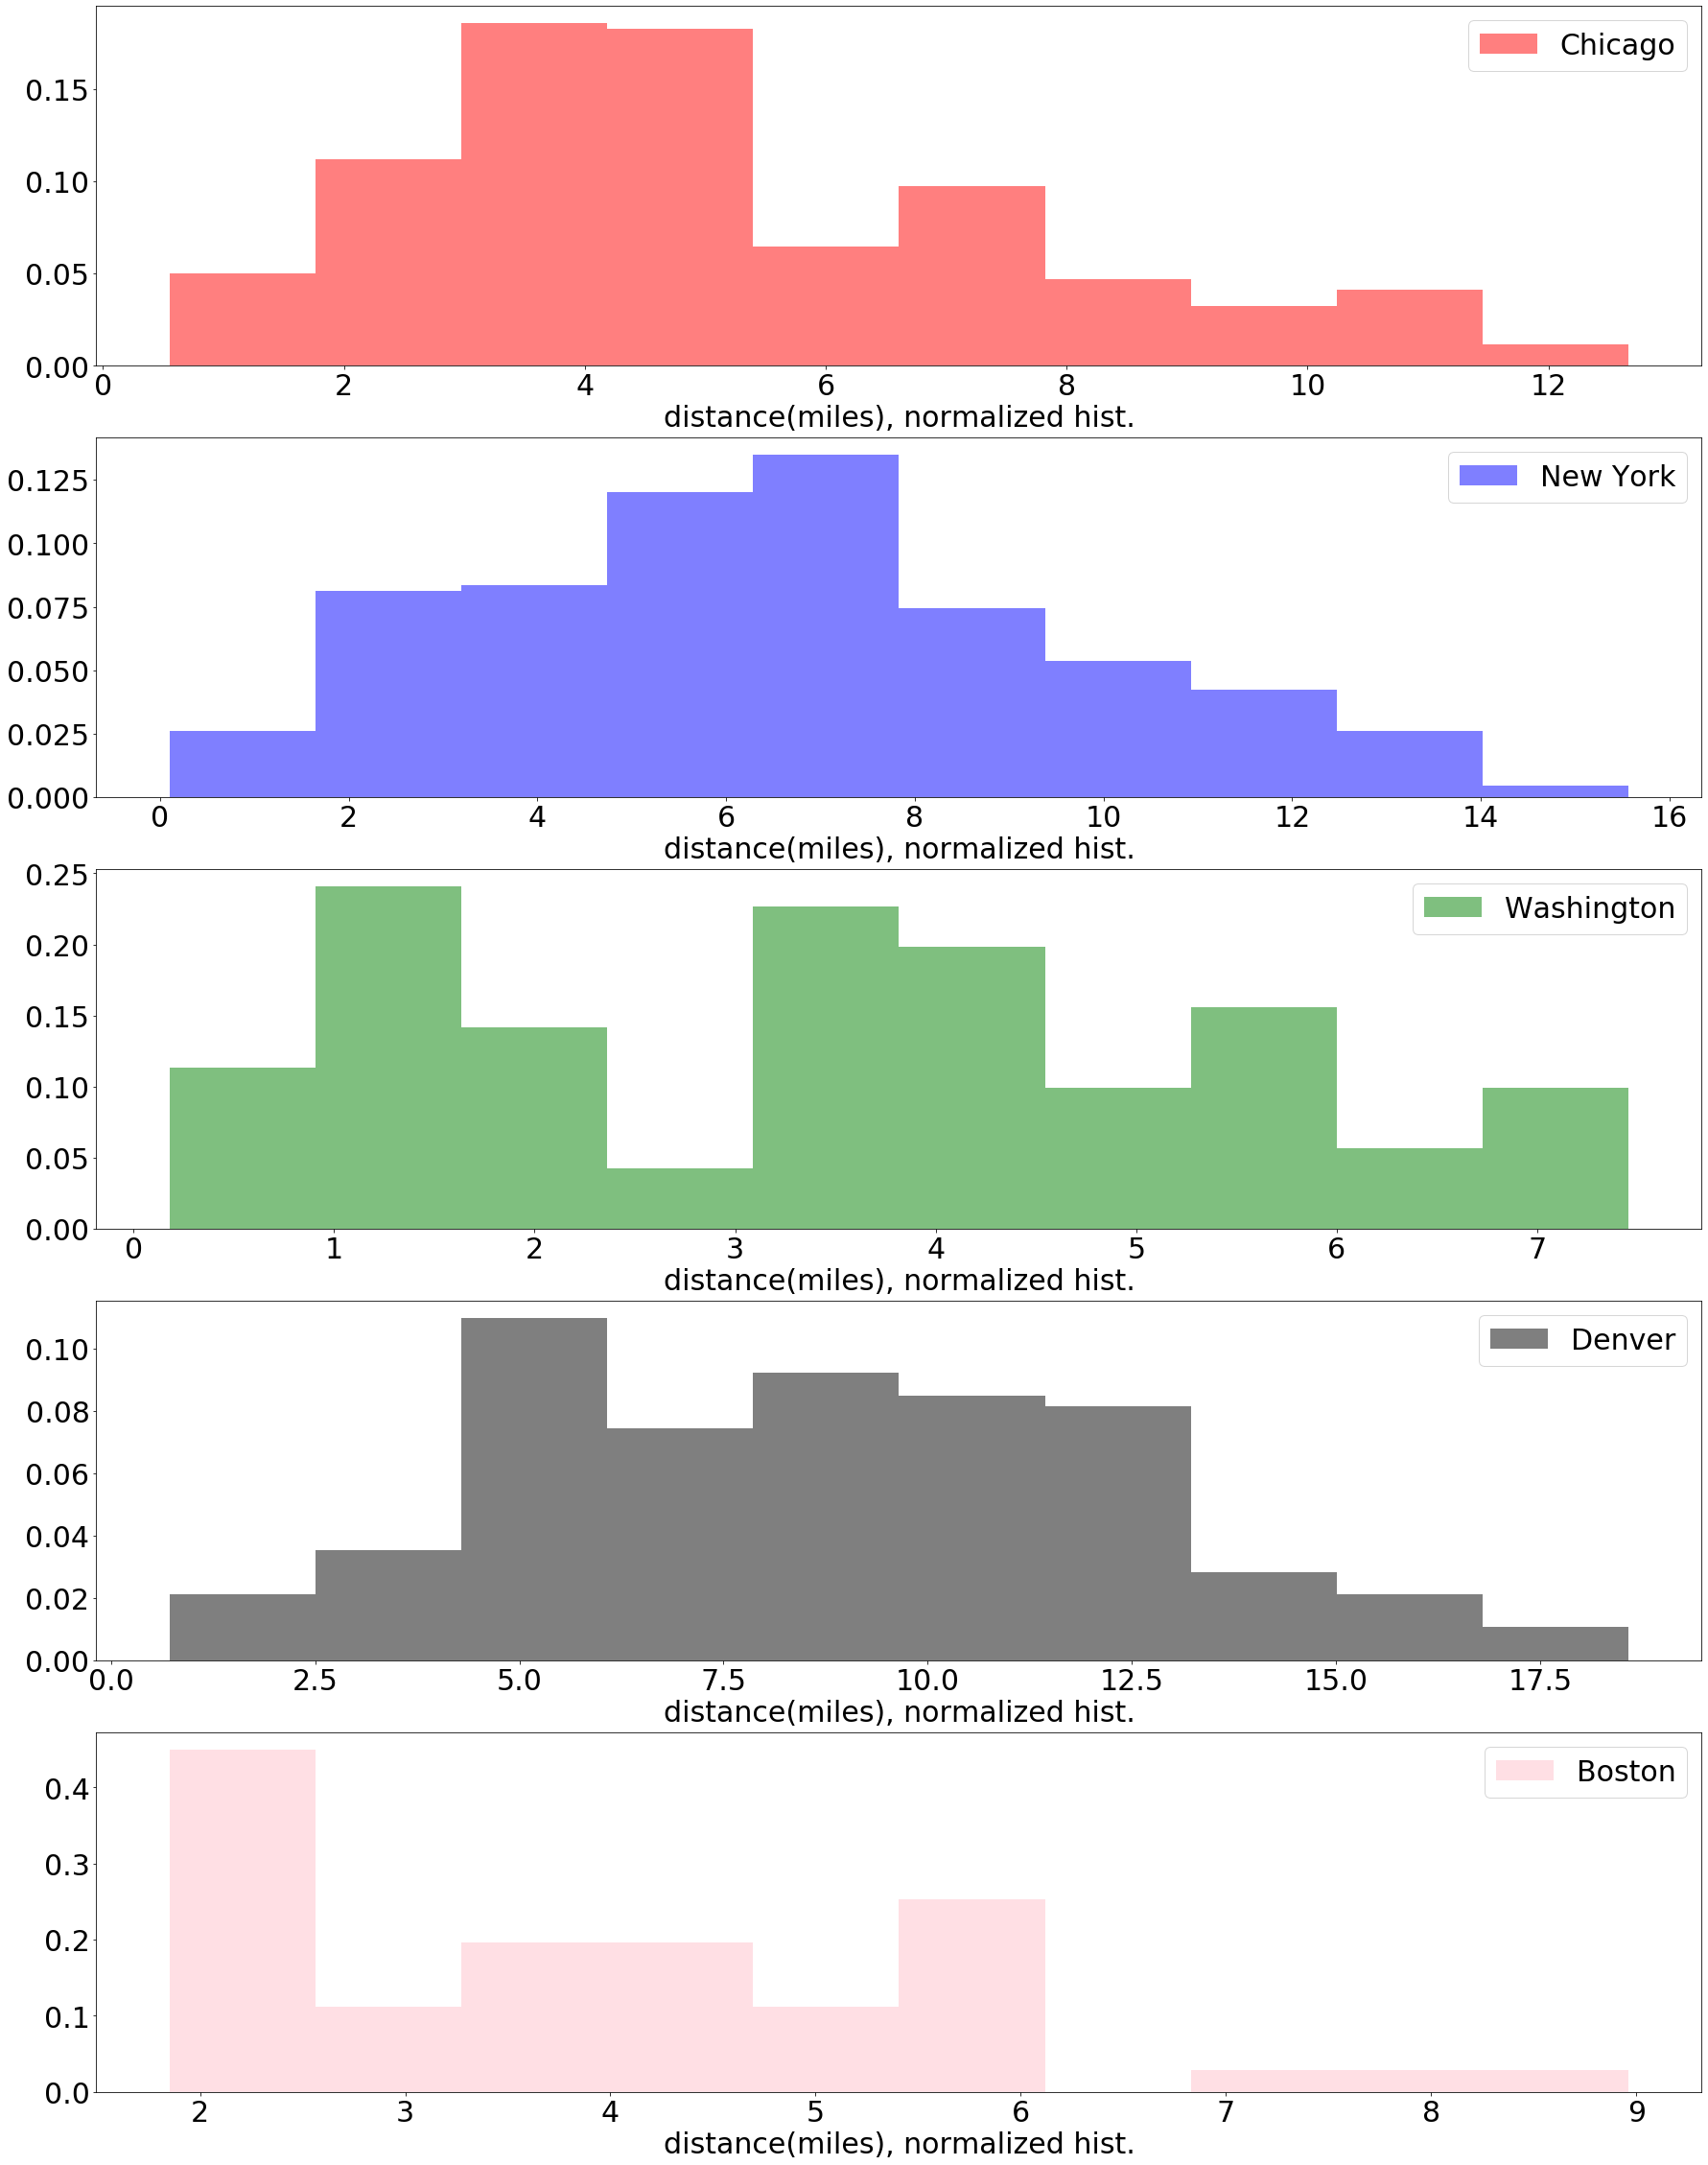

In [37]:
import matplotlib 
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
fig, ax = plt.subplots(figsize = (30,40))
plt.title('distance of traveller destinations from metro centers')
for i, var in enumerate(metros):
    plt.subplot(5,1,i+1)
    
    plt.hist(df_tr[df_tr['within_metro']==var]['miles'],alpha = 0.5,color = c[i],density = True,label = var)
    
    plt.xlabel('distance(miles), normalized hist.', fontsize = 30)
    #plt.title('distance of traveller destinations from metro centers')
    plt.legend(fontsize = 30)
    ;

### New York and Denver sprawl is max 16-18 miles

''

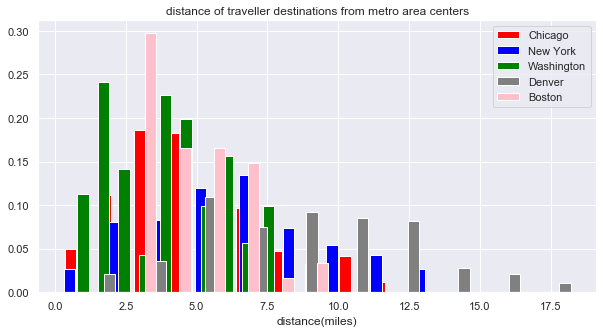

In [38]:
import seaborn as sns
import numpy as np
sns.set()
fig, ax = plt.subplots(figsize = (10,5))
a_heights, a_bins = np.histogram(df_tr[df_tr['within_metro']=='Chicago']['miles'],density = True)
b_heights, b_bins = np.histogram(df_tr[df_tr['within_metro']=='New York']['miles'],density = True)
c_heights, c_bins = np.histogram(df_tr[df_tr['within_metro']=='Washington']['miles'],density = True)
d_heights, d_bins = np.histogram(df_tr[df_tr['within_metro']=='Denver']['miles'],density = True)

e_heights, e_bins = np.histogram(df_tr[df_tr['within_metro']=='Boston']['miles'], bins=a_bins,density = True)



width = (a_bins[1] - a_bins[0])/3
ax.bar(a_bins[:-1], a_heights, width=width, facecolor='red', label = 'Chicago')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='blue', label = 'New York')
ax.bar(c_bins[:-1]+2*width, c_heights, width=width, facecolor='green', label = 'Washington')
ax.bar(d_bins[:-1]+3*width, d_heights, width=width, facecolor='grey', label = 'Denver')
ax.bar(e_bins[:-1]+4*width, e_heights, width=width, facecolor='pink', label = 'Boston')

ax.legend()
plt.xlabel('distance(miles)')
plt.title('distance of traveller destinations from metro area centers')
;

#plt.hist(df_tr[df_tr['within_metro']=='Chicago']['miles'], label = 'Chicago');

### Save new created travellers database

In [299]:
#df_tr.to_csv("data/travellers_selection.csv", index=False)

In [39]:
df_tr.columns

Index(['city', 'id', 'latitude', 'longitude', 'destination', 'num_types',
       'state', 'types_rating', 'date', 'latitude_radians',
       'longitude_radians', 'within_metro', 'miles'],
      dtype='object')